## import libraries, initialize Spark server

In [1]:
import numpy as np               # for mathematic array
import pandas as pd              # for csv reading
import matplotlib.pyplot as plt  # for visualization
%matplotlib inline               
from graphviz import Digraph

In [2]:
from pyspark import SparkConf, SparkContext
import operator
import math

conf = SparkConf().setMaster("yarn").setAppName("Lab06")
sc = SparkContext(conf=conf)

In [3]:
sc

<SparkContext master=yarn appName=Lab06>

In [4]:
dataText = sc.textFile("golf.data")
dataText.collect()

['Sunny,Hot,High,Weak,No',
 'Sunny,Hot,High,Strong,No',
 'Overcast,Hot,High,Weak,Yes',
 'Rain,Mild,High,Weak,Yes',
 'Rain,Cool,Normal,Weak,Yes',
 'Rain,Cool,Normal,Strong,No',
 'Overcast,Cool,Normal,Strong,Yes',
 'Sunny,Mild,High,Weak,No',
 'Sunny,Cool,Normal,Weak,Yes',
 'Rain,Mild,Normal,Weak,Yes',
 'Sunny,Mild,Normal,Strong,Yes',
 'Overcast,Mild,High,Strong,Yes',
 'Overcast,Hot,Normal,Weak,Yes',
 'Rain,Mild,High,Strong,No',
 'Sunny,Cool,Normal,Weak,No',
 'Sunny,Cool,Normal,Weak,Yes',
 'Sunny,Hot,Normal,Weak,No',
 'Sunny,Hot,Normal,Weak,No',
 'Sunny,Mild,Normal,Weak,Yes',
 'Sunny,Mild,Normal,Weak,No']

In [5]:
data = dataText.map(lambda s: tuple(s.rsplit(',')))
data.collect()

[('Sunny', 'Hot', 'High', 'Weak', 'No'),
 ('Sunny', 'Hot', 'High', 'Strong', 'No'),
 ('Overcast', 'Hot', 'High', 'Weak', 'Yes'),
 ('Rain', 'Mild', 'High', 'Weak', 'Yes'),
 ('Rain', 'Cool', 'Normal', 'Weak', 'Yes'),
 ('Rain', 'Cool', 'Normal', 'Strong', 'No'),
 ('Overcast', 'Cool', 'Normal', 'Strong', 'Yes'),
 ('Sunny', 'Mild', 'High', 'Weak', 'No'),
 ('Sunny', 'Cool', 'Normal', 'Weak', 'Yes'),
 ('Rain', 'Mild', 'Normal', 'Weak', 'Yes'),
 ('Sunny', 'Mild', 'Normal', 'Strong', 'Yes'),
 ('Overcast', 'Mild', 'High', 'Strong', 'Yes'),
 ('Overcast', 'Hot', 'Normal', 'Weak', 'Yes'),
 ('Rain', 'Mild', 'High', 'Strong', 'No'),
 ('Sunny', 'Cool', 'Normal', 'Weak', 'No'),
 ('Sunny', 'Cool', 'Normal', 'Weak', 'Yes'),
 ('Sunny', 'Hot', 'Normal', 'Weak', 'No'),
 ('Sunny', 'Hot', 'Normal', 'Weak', 'No'),
 ('Sunny', 'Mild', 'Normal', 'Weak', 'Yes'),
 ('Sunny', 'Mild', 'Normal', 'Weak', 'No')]

## Support function

In [6]:
def is_purity(examples):
    '''
        examples: rdd
    '''      
    if examples.count() == 0:
        return True

    count_unique_classes = examples.map(lambda x: (x[-1], 0)).reduceByKey(lambda x, y: x+y).count()
    if count_unique_classes == 1:
        return True
    
    return False
# --------------------------------------------------------
def data_filter(examples, value, attribute_index):

    return examples.filter(lambda x: x[attribute_index] == value)

# --------------------------------------------------------
def entropy(examples):
    '''
        examples: rdd
    '''
    
    count = examples.count()
    yes_count = examples.filter(lambda x: x[-1] == 'Yes').count()
    no_count = count - yes_count
    
    result = 0
    if yes_count > 0:
        result = -yes_count/count * math.log(yes_count/count, 2)
    if no_count > 0:
        result += -no_count/count * math.log(no_count/count, 2)
    return result
    
# -----------------------------------------------------------------------------------
def information_gain(examples, dict_values, dict_indices, attribute):
    '''
        examples: rdd
        attribute_values: dictionary (set of available value by attribute in dataset)
        attribute: string ('outlook', 'temperature', ...)
    '''
    
    attribute_index = dict_indices.get(attribute)
    count = examples.count()
    
    IG = entropy(examples)
    for value in dict_values.get(attribute):
        new_examples = data_filter(examples, value, attribute_index)
        new_count = new_examples.count()
        if new_count > 0:
            IG = IG - new_count/count * entropy(new_examples)
    
    return IG

# -----------------------------------------------------------------------------------
def find_best_attribute(examples, dict_values, dict_indices, available_attributes):
    max_gain = 0
    selected_attribute = ''
    for attribute in available_attributes:
        gain = information_gain(examples, dict_values, dict_indices, attribute)
        if gain >= max_gain:
            max_gain = gain
            selected_attribute = attribute
    return selected_attribute
# -----------------------------------------------------------------------------------
def percentage(examples):
    count = examples.count()
    if count < 1:
        return 'N/A', 'N/A'
    
    yes_count = examples.filter(lambda x: x[-1] == 'Yes').count()
    no_count = count - yes_count
    
    yes_percentage = str(round(yes_count/count * 100, 2)) + '% yes'
    no_percentage = str(round(no_count/count * 100, 2)) + '% no'
    
    return (yes_percentage, no_percentage)

## algorithm

In [7]:
# Corresponding indices of attributes for each training example
dict_indices = {
    'outlook': 0,
    'temperature': 1,
    'humidity': 2,
    'wind': 3,
    'label': 4
}

# Domain values of attributes
dict_values = {
    'outlook': ['Sunny', 'Overcast', 'Rain'],
    'temperature': ['Hot', 'Mild', 'Cool'],
    'humidity': ['High', 'Normal'],
    'wind': ['Weak', 'Strong']
}

# available attribute (after spliting, the attribute shoud be removed from list)
available_attributes = np.array(['outlook', 'temperature', 'humidity', 'wind'])

In [8]:
class Global:
    id = 0
    
# -----------------------------------------------------------------------------------------------------------------
class Leaf:
    
    def __init__(self, brand, values):
        
        # brand is the previous value that lead to this node from parent node
        # ex: (outlook, Rain)->(89% yes, 11% no) --> brand of leaf is 'Rain'
        self.brand = brand
        self.values = values

        # update global id (each Leaf, DecisionNode has different node_id)
        self.node_id = Global.id
        Global.id += 1
        
    def is_leaf(self):
        return True

# -----------------------------------------------------------------------------------------------------------------
class DecisionNode:
    def __init__(self, brand, attribute):

        # brand is the previous value that lead to this node from parent node
        # ex: (outlook, Rain) -> (temperature, Hot) --> brand of child node is 'Rain', attribute is 'temperature'        
        self.attribute = attribute
        self.brand = brand
        self.nexts = []

        # update global id (each Leaf, DecisionNode has different node_id)
        self.node_id = Global.id
        Global.id += 1        
        
    def is_leaf(self):
        return False
    
    def brand_in_next(self, brand):
        for node in self.nexts:
            if node.brand == brand:
                return True
        return False
    
    def get_child_by_brand(self, brand):
        for node in self.nexts:
            if node.brand == brand:
                return node
        return None
    
# -----------------------------------------------------------------------------------------------------------------
class Tree:
    def __init__(self):
        
        self.root = None
    # --------------------------------------------------------------------------------
    def insert(self, my_node, path, result):
        
        if len(path) == 1:
            brand = path[0][1]
            child = Leaf(brand, result)
            my_node.nexts.append(child)
            return

        if self.root is None:
            # when the root is initialize for the first time
            
            self.root = DecisionNode(None, path[0][0])
            return self.insert(self.root, path, result)
        else:
            
            brand = path[0][1]
            if my_node.brand_in_next(brand):
                return self.insert(my_node.get_child_by_brand(brand), path[1:], result)
            else:
                child = DecisionNode(brand, path[1][0])
                my_node.nexts.append(child)
                return self.insert(my_node.get_child_by_brand(brand), path[1:], result)
    # ---------------------------------------------------------------------------------
    def predict(self, my_node, dict_indices, features):
        
        if my_node.is_leaf():
            return my_node.values
        else:
            attribute = my_node.attribute
            index = dict_indices.get(attribute)
            brand = features[index]
            child = my_node.get_child_by_brand(brand)
            return self.predict(child, dict_indices, features)
    # ---------------------------------------------------------------------------------
    def build_visualize(self, my_node, my_visualize_tree):
        
        if not my_node.is_leaf():
            my_visualize_tree.node(str(my_node.node_id), my_node.attribute, shape='diamond')
            
            for node in my_node.nexts:
                self.build_visualize(node, my_visualize_tree)
                my_visualize_tree.edge(str(my_node.node_id), str(node.node_id), label=node.brand)            
        else:
            my_visualize_tree.node(str(my_node.node_id), my_node.values[0], shape='oval')    
            
            

In [9]:
def running_algorithm(my_tree, examples, dict_values, dict_indices, available_attributes, path):
    
    if is_purity(examples):
        percent = percentage(examples)
        print(path, percent[0], percent[1])
        print()
        my_tree.insert(my_tree.root, path, (percent[0], percent[1]))
        return
    
    if len(available_attributes) < 1:
        percent = percentage(examples)
        print(path, percent[0], percent[1])
        print()
        my_tree.insert(my_tree.root, path, (percent[0], percent[1]))
        return
    
    # get attribute with highest IG to split
    attribute = find_best_attribute(examples, dict_values, dict_indices, available_attributes)    
    attribute_index = dict_indices.get(attribute)
    
    # update the available attribute (children node can't use their parent's attribute to split)
    new_available_attributes = np.delete(available_attributes, np.argwhere(available_attributes == attribute))
    
    # for each value of chosen attribute, try spliting them
    for value in dict_values.get(attribute):
        path.append((attribute, value))
        new_examples = data_filter(examples, value, attribute_index)
        # if new_examples.count() > 0:
        running_algorithm(my_tree, new_examples, dict_values, dict_indices, new_available_attributes, path)
        path.pop()

In [10]:
my_tree = Tree()

running_algorithm(my_tree, data, dict_values, dict_indices, available_attributes, [])

[('outlook', 'Sunny'), ('temperature', 'Hot')] 0.0% yes 100.0% no

[('outlook', 'Sunny'), ('temperature', 'Mild'), ('wind', 'Weak'), ('humidity', 'High')] 0.0% yes 100.0% no

[('outlook', 'Sunny'), ('temperature', 'Mild'), ('wind', 'Weak'), ('humidity', 'Normal')] 50.0% yes 50.0% no

[('outlook', 'Sunny'), ('temperature', 'Mild'), ('wind', 'Strong')] 100.0% yes 0.0% no

[('outlook', 'Sunny'), ('temperature', 'Cool'), ('wind', 'Weak'), ('humidity', 'High')] N/A N/A

[('outlook', 'Sunny'), ('temperature', 'Cool'), ('wind', 'Weak'), ('humidity', 'Normal')] 66.67% yes 33.33% no

[('outlook', 'Sunny'), ('temperature', 'Cool'), ('wind', 'Strong')] N/A N/A

[('outlook', 'Overcast')] 100.0% yes 0.0% no

[('outlook', 'Rain'), ('wind', 'Weak')] 100.0% yes 0.0% no

[('outlook', 'Rain'), ('wind', 'Strong')] 0.0% yes 100.0% no



## Predict

In [11]:
features = ['Sunny', 'Cool', 'Normal', 'Weak']

print(my_tree.predict(my_tree.root, dict_indices, features))

('66.67% yes', '33.33% no')


## Decision Tree visualization

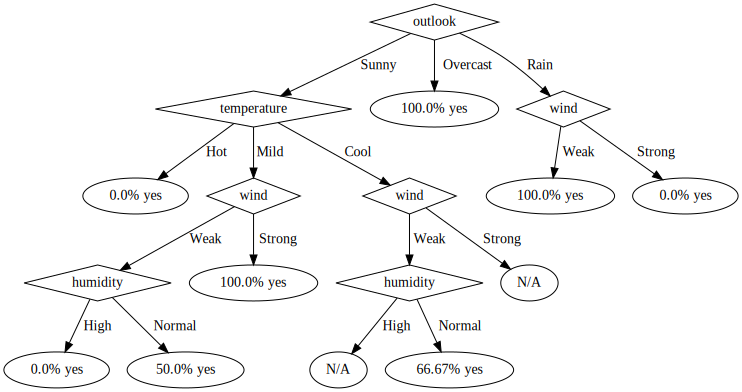

In [12]:
tree_visualization = Digraph(comment='decision tree')
my_tree.build_visualize(my_tree.root, tree_visualization)

tree_visualization